## Building Recommender Systems using Graph Neural Networks (GNNs)



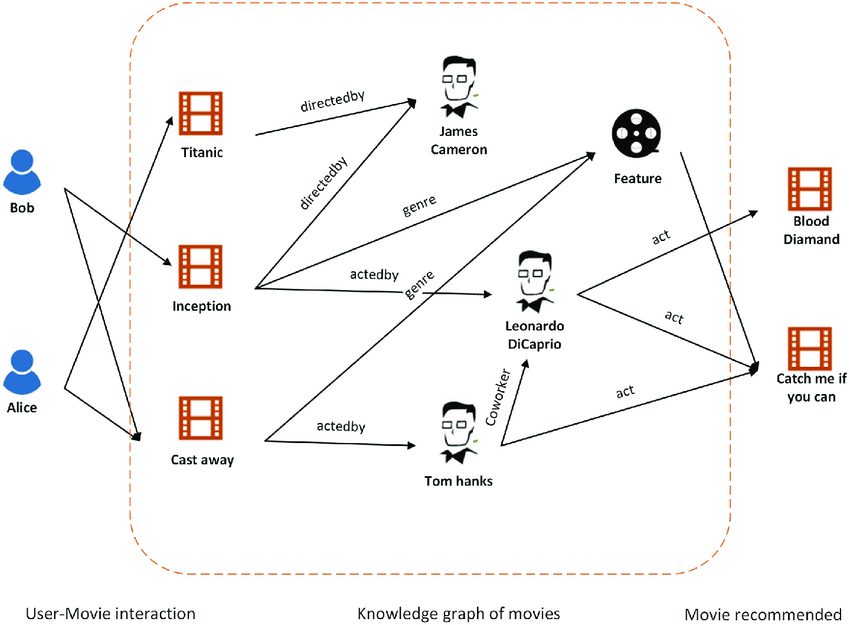



*Image source: Xintao et.al.*

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2024/blob/main/practicals/Recommender_Systems/GNNs_for_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning Indaba 2024. Apache License 2.0.

**Authors:** [Jama Hussein Mohamud](https://engmubarak48.github.io/jmohamud/) 

**Reviewers:**
[Matthew Morris](https://www.cs.ox.ac.uk/people/matthew.morris/)

**Introduction:**

This tutorial builds upon the knowledge gained from the Graph Neural Networks and Recommender Systems tutorials. In this section, we will show how to leverage Graph Neural Networks in recommender systems. In your free time, also feel free to have a look at this in-depth [introduction](https://aman.ai/recsys/gnn/) on GNNs for recommender systems.

**Prerequisites:**

- Familiarity with JAX, especially Flax and Jraph
- A solid grasp of neural network fundamentals
- Completion of the Graph Neural Networks (GNNs) tutorial
- Completion of the Recommender Systems tutorial

**Aims/Learning Objectives:**
- Frame link prediction tasks within the context of movie recommendations
- Implement a Graph Convolutional Network (GCN) for movie recommendations

**Topics:**

Content: Machine Learning, Recommender Systems, Graph Neural Networks


###  Setup, Installation and Data

Please run the below cells before starting the tutorial.


We'll be using `jraph`, a library for working with graph neural networks in JAX.

Run the following cell to install `jraph` and downlaod the data:

In [ ]:
%%capture
# Installations
!pip install git+https://github.com/deepmind/jraph.git
# graph data download
!wget https://github.com/engmubarak48/indaba-pracs-2024/blob/recommender-systems/practicals/data.pt

#### Import Required Libraries

In this section, we'll import the necessary libraries for our GNN-based recommender system.
Run the following cell to import the required packages:

In [ ]:
# @title Import required packages.

import jax
import jraph
import optax
import torch
import itertools
import numpy as np
import pandas as pd
from flax import linen as nn
from jax import numpy as jnp
import jax.tree_util as tree
import matplotlib.pyplot as plt
from jraph import GraphConvolution
from flax.training import train_state
from typing import Mapping, Sequence, Tuple, Callable

### **1.1 Introduction**

Graphs are a powerful and versatile representation of data with a wide range of applications. While most people are familiar with their use in contexts such as social networks and biological systems, graphs also have been used in recommender systems, which is the focus of this tutorial.

### **1.2. Graph Prediction Tasks**

As demonstrated in the GNN tutorial there are mainly three graph tasks in the context of graph neural networks:

1. **Node Classification**: E.g. what is the topic of a paper given a citation network of papers?
2. **Link Prediction / Edge Classification**: E.g. are two people in a social network friends?
3. **Graph Classification**: E.g. is this protein molecule (represented as a graph) likely going to be effective?

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_tasks.png" width="700px">

*Image source: Petar Veličković.*


### **1.3. Recommender Systems as a Link Prediction Problem**

A recommender system can be visualized as a graph, where entities (such as users and items) are nodes, and the interactions between them (such as ratings or purchase history) are edges. In the movie recommendation system:

- Nodes represent:
  - Users: Individuals consuming the content
  - Movies: Content items to be recommended

- Edges represent:
  - Ratings: Directed edges from users to movies, weighted to indicate the rating (e.g., on a scale of 1 to 5)

#### 1.3.1. Link (or Edge) Prediction

Link prediction aims to determine whether a link (or edge) should exist between two nodes, even if it's currently absent. In our movie recommendation system, this translates to predicting whether a user would like (or dislike) a movie they haven't yet rated.

The process works as follows:

1. Train on existing nodes and edges: use existing existing edge features (e.g. rating) and user-movie node features (e.g. movie genres) to train a model.
2. Predict missing edges: for a given user, predict ratings for movies they haven't seen or rated. This is equivalent to predicting missing or potential edges in our graph.
3. Recommend based on predictions: suggest movies with the highest predicted ratings to the user.

In this section of the tutorial, we will leverage Graph Neural Networks (GNNs) for this link prediction task. GNNs operate on the graph, aggregating information from neighboring nodes to produce accurate predictions for missing edges.

#### **1.4 Read Data**

In this section, we load a pre-processed graph version of the MovieLens data, which is used in the Recommender Systems tutorial, from a PyTorch Geometric Data object saved as `data.pt`.

This graph representation is prepared for use with our GNN model and will be the primary data structure used during model training. If you are interested in how we transformed the original MovieLens data into a graph format, please refer to the file [generate_graph.py](https://github.com/engmubarak48/indaba-pracs-2024/blob/recommender-systems/practicals/generate_graph.py). Note that unlike the last year's [tutorial](https://github.com/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/Recommender_Systems.ipynb), where user node features were randomly generated from an embedding matrix, in this tutorial we will use learnable feature embeddings for each user.


In [ ]:
#@title Data

# Load graph data
data = torch.load(f"data.pt")
data.keys

['num_users',
 'movie_id_to_title',
 'train_mask',
 'val_mask',
 'x',
 'edge_attr',
 'edge_index',
 'test_mask']

`num_users` indicate the total number of unique users in the dataset.

In [ ]:
data.num_users

610

The `movie_id_to_title` is simply a mapping from user IDs to their corresponding movie titles in the graph. We will use this for inference.

In [ ]:
# show 5 elements from movie_id_to_title

dict(itertools.islice(data.movie_id_to_title.items(), 5))

{3580: 'One Crazy Summer (1986)',
 2888: 'Friday the 13th Part VI: Jason Lives (1986)',
 1332: 'Trail of the Pink Panther (1982)',
 9299: 'Do You Remember Dolly Bell? (Sjecas li se, Dolly Bell) (1981)',
 3134: 'Bronson (2009)'}

`x` contains the node features matrix where each row represents a node (user or movie) and columns are feature values.

In [ ]:
# node features
print('first 5 user node features')
print(data.x[:5])

print('Last 5 movie node features')
print(data.x[-5:])

first 5 user node features
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Last 5 movie node features
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.]])

In the node features (`x`), the features corresponding to users are initially set to zeros. These will be replaced within the model by learnable embedding features (i.e. every user will have an embedding which is learned during the training of the model). Movie node features, on the other hand, are represented using one-hot encoding of the movie genres. Although it's possible to include movie titles as part of the node features, we have opted for simplicity in this tutorial and only use one-hot encoding of movie genres.


The `edge_attr` contains the edge features which, in our case, correspond to the user ratings.

In [ ]:
# edge features
data.edge_attr[:5]

tensor([[5.0000],
        [4.5000],
        [4.0000],
        [0.5000],
        [3.0000]])

The `edge_index` is a key component of our graph structure, representing the connections between nodes. In our movie recommendation system, each entry in the `edge_index` shows a link between a user and a movie.

In [ ]:
# edge index
print(data.edge_index[:3])

tensor([[   0,    1,    2,  ...,  183,  415,  442],
        [ 610,  611,  612,  ...,  947, 1447,  937]])


`train_mask` is a boolean mask used to select the subset of data (edges) for training. `val_mask` and `test_mask` are the same but for validation and test sets respectively.

In [ ]:
# masks

print(f'First 3 elements of train mask: {data.train_mask.flatten()[:3]}')
print(f'First 3 elements of val mask: {data.val_mask.flatten()[:3]}')
print(f'First 3 elements of test mask: {data.test_mask.flatten()[:3]}')

First 3 elements of train mask: [False False  True]
First 3 elements of val mask: [ True False False]
First 3 elements of test mask: [False  True False]


Let us do a preliminary exploration of the data. For instance, let us print the number of unique users and movies.

In [ ]:
# Number of unique users
num_users = data.num_users
print(f"Number of unique users: {num_users}")

# Number of unique movies
num_movies = len(data.movie_id_to_title)
print(f"Number of unique movies: {num_movies}")

Number of unique users: 610
Number of unique movies: 9724


Below we will visualize the distribution of user ratings.

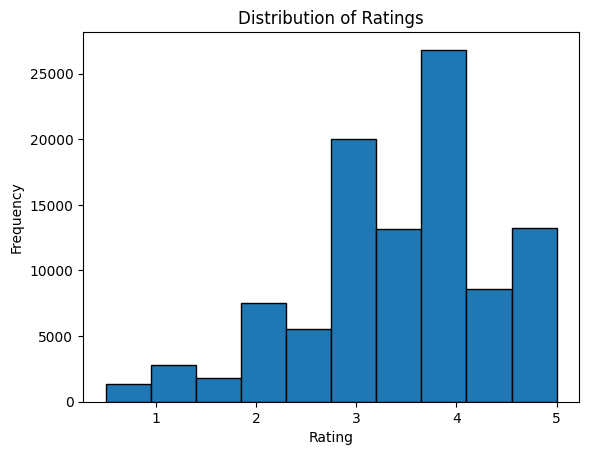

In [ ]:
import matplotlib.pyplot as plt

# Extract ratings from edge_attr
ratings = data.edge_attr.numpy()

# Plot the distribution of ratings
plt.hist(ratings, bins=10, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

We can observe that the most frequent ratings provided are 3 and 4.

We need to change our graph data into a format that Jax's `Jraph` framework can use. The function below converts our graph into `jraph.GraphsTuple`, which is compatible with Jraph library.

In [ ]:
#@title Helper function

# A helper function to convert our graph data into jraph.GraphsTuple
def convert_to_jraph(data):
    """ Convert the Pytorch Data Object """
    graph = jraph.GraphsTuple(
        nodes=np.array(data.x),
        edges=np.array(data.edge_attr),
        n_node=np.array([data.num_nodes]),
        n_edge=np.array([data.num_edges]),
        senders=np.array(data.edge_index[0]),  # users are source
        receivers=np.array(data.edge_index[1]),  # movies are recievers
        globals={"num_users": data.num_users},
    )
    train_mask, val_mask, test_mask = np.array(data.train_mask), np.array(data.val_mask), np.array(data.test_mask)
    return graph, train_mask, val_mask, test_mask

In [ ]:
#@title Convert the graph to jraph.GraphsTuple

graph, train_mask, val_mask, test_mask = convert_to_jraph(data=data)
graph

GraphsTuple(nodes=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), edges=array([[5. ],
       [4.5],
       [4. ],
       ...,
       [4. ],
       [5. ],
       [3.5]], dtype=float32), receivers=array([ 610,  611,  612, ...,  947, 1447,  937]), senders=array([  0,   1,   2, ..., 183, 415, 442]), globals={'num_users': 610}, n_node=array([10334]), n_edge=array([100836]))

#### **1.5 Graph Convolutional Networks (GCNs) in Recommender Systems**

We'll use a Graph Convolutional Network (GCN) as our model. GCNs are well-suited for recommender systems, addressing key challenges:

- **Handling Sparse Data**: They efficiently manage sparse user-item interactions by utilizing the inherent graph structure.
- **Capturing Complex Relationships**: GCNs excel at learning the complex and non-linear relationships represented in the user-item interaction graph.
- **Incorporating Side Information**: They allow integration of additional features such as user rating, demographics or item descriptions directly into the graph.

For more in-depth understanding of the GCN architecture, please go through the GNN Tutorial and other provided resources in the beginning of this tutorial.

The below class defines a simple Multi-Layer Perceptron (MLP) module that updates features during the message passing in our GCN.

In [ ]:
#@task

class MLP(nn.Module):
  """A flax MLP."""
  features: Sequence[int]
  kernel_init: Callable = jax.nn.initializers.he_uniform()
  bias_init: Callable = jax.nn.initializers.zeros

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i, feat in enumerate(self.features):
        lyr = nn.Dense(feat, kernel_init=self.kernel_init, bias_init=self.bias_init, name=f"mlp_dense_{i}")
        x = # Apply the dense layer to x
        x = # Add relu non-linearity
        if i != len(self.features) - 1:
            x = nn.relu(x)
    return x

In [ ]:
#@title solution

class MLP(nn.Module):
  """A flax MLP."""
  features: Sequence[int]
  kernel_init: Callable = jax.nn.initializers.he_uniform()
  bias_init: Callable = jax.nn.initializers.zeros

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i, feat in enumerate(self.features):
        lyr = nn.Dense(feat, kernel_init=self.kernel_init, bias_init=self.bias_init, name=f"mlp_dense_{i}")
        x = lyr(x)
        x = nn.relu(x)
        if i != len(self.features) - 1:
            x = nn.relu(x)
    return x

##### **1.5.1 Graph Convolution Layer**

This class implements a Graph Convolution Layer that starts by embedding user features, then combines these with movie nodes to process through the network. The layer utilizes an attention mechanism to weigh the importance of edges, thereby aggregating messages at nodes. Optional layer normalization can be applied to stabilize the model during training. Finally, it predicts edge values using a simple dense layer and scales these predictions to a 1-5 scale.

This model's attention mechanism is determined based on edge features alone, not the features of the connecting nodes, aligning it more closely with Graph Attention Networks (GATs) rather than traditional Graph Convolutional Networks (GCNs). In GATs, attention coefficients are computed to signify the importance of every node to its neighbors, thus enhancing the model's ability to capture complex relational data.

For those familiar with GCNs from our GNN tutorial, the key difference here is how node connectivity influences the aggregation process. While GCNs use a simple weighted sum based on edge weights, GATs, like our model, adjust these weights through a learned attention mechanism.

If the concept of attention is new to you, or if you require a more detailed understanding of how GATs function, please refer to the extended sections of the GNN practical where GATs are discussed in more depth.


In [ ]:
#@ task

# Graph Convolution Model Definition

class GraphConvLayer(nn.Module):
    output_decoder_dim: int
    num_user_nodes: int
    update_node_fn: Callable
    attention_logit_fn: Callable
    aggregate_nodes_fn: Callable = jax.ops.segment_sum
    add_self_edges: bool = False
    symmetric_normalization: bool = True
    layer_norm: bool = False

    @nn.compact
    def __call__(self, graph):
        # Embed the user features
        user_indices = jnp.arange(self.num_user_nodes)
        emb = nn.Embed(self.num_user_nodes, graph.nodes.shape[1])
        user_embeddings = emb(user_indices)

        # graph.nodes should be structured such that user nodes come first, followed by movie nodes
        nodes = jnp.concatenate([user_embeddings, graph.nodes[self.num_user_nodes:]], axis=0)
        edge_weights = self.attention_logit_fn(graph.edges)
        edge_weights = jraph.segment_softmax(edge_weights, segment_ids=graph.receivers, num_segments=nodes.shape[0])
        messages =  # Multiply sender messages by the edge weights
        nodes = self.aggregate_nodes_fn(messages, graph.receivers, num_segments=graph.nodes.shape[0])
        graph = graph._replace(nodes=nodes)

        gcn = GraphConvolution(
            update_node_fn=self.update_node_fn,
            aggregate_nodes_fn=self.aggregate_nodes_fn,
            add_self_edges=self.add_self_edges,
            symmetric_normalization=self.symmetric_normalization
        )
        graph = # Apply gcn to the graph
        if self.layer_norm:
            # Apply layer normalization to the node embeddings
            normalized_nodes = nn.LayerNorm()(graph.nodes)
            graph = # Update the graph with the normalized node embeddings

        edge_predictions = jnp.sum(graph.nodes[graph.senders] * graph.nodes[graph.receivers], axis=-1)
        edge_predictions = jnp.expand_dims(edge_predictions, axis=1)
        edge_predictions = nn.Dense(self.output_decoder_dim, name="mlp_dense_output")(edge_predictions)


        edge_predictions = # Apply sigmoid activation to the edge_predictions and scale it to a 1-5 scale
        return edge_predictions

In [ ]:
#@title Solution

class GraphConvLayer(nn.Module):
    output_decoder_dim: int
    num_user_nodes: int
    update_node_fn: Callable
    attention_logit_fn: Callable
    aggregate_nodes_fn: Callable = jax.ops.segment_sum
    add_self_edges: bool = False
    symmetric_normalization: bool = True
    layer_norm: bool = False

    @nn.compact
    def __call__(self, graph):
        # Embed the user features
        user_indices = jnp.arange(self.num_user_nodes)
        emb = nn.Embed(self.num_user_nodes, graph.nodes.shape[1])
        user_embeddings = emb(user_indices)

        # graph.nodes should be structured such that user nodes come first, followed by movie nodes
        nodes = jnp.concatenate([user_embeddings, graph.nodes[self.num_user_nodes:]], axis=0)
        edge_weights = self.attention_logit_fn(graph.edges)
        edge_weights = jraph.segment_softmax(edge_weights, segment_ids=graph.receivers, num_segments=nodes.shape[0])
        messages =  nodes[graph.senders] * edge_weights
        nodes = self.aggregate_nodes_fn(messages, graph.receivers, num_segments=graph.nodes.shape[0])
        graph = graph._replace(nodes=nodes)

        gcn = GraphConvolution(
            update_node_fn=self.update_node_fn,
            aggregate_nodes_fn=self.aggregate_nodes_fn,
            add_self_edges=self.add_self_edges,
            symmetric_normalization=self.symmetric_normalization
        )
        graph = gcn(graph)
        if self.layer_norm:
            # Apply layer normalization to the node embeddings
            normalized_nodes = nn.LayerNorm()(graph.nodes)
            # Update the graph with the normalized node embeddings
            graph = graph._replace(nodes=normalized_nodes)

        edge_predictions = jnp.sum(graph.nodes[graph.senders] * graph.nodes[graph.receivers], axis=-1)
        edge_predictions = jnp.expand_dims(edge_predictions, axis=1)
        edge_predictions = nn.Dense(self.output_decoder_dim, name="mlp_dense_output")(edge_predictions)

        # Apply sigmoid activation and scale it
        edge_predictions = 4 * jax.nn.sigmoid(edge_predictions) + 1
        return edge_predictions

##### Initialize the GCN Layer

Here, we define a single-layer Graph Convolution Network (GCN) with specific functions for attention, node updates, and aggregation.
We initialize the model to check the output shapes, ensuring everything is set up correctly before training.


In [ ]:
# Define one layer gcn
gcn_layer = GraphConvLayer(
    output_decoder_dim = 1,
    attention_logit_fn=lambda n: MLP(features=[64, 1])(n),
    update_node_fn=lambda n: MLP(features=[64, 64])(n),
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges=False,
    symmetric_normalization=True,
    num_user_nodes=graph.globals['num_users'],
)

# Initialize to see the output shapes
params = gcn_layer.init(jax.random.PRNGKey(42), graph)
output = gcn_layer.apply(params, graph)
output.shape, graph.edges.shape

((100836, 1), (100836, 1))

##### Define the L1 Loss Function

This function calculates the L1 loss, which measures the difference between predicted values and actual values. We apply a mask to focus only on train, val or test sets.
You can choose to average the loss across all data points or sum.


In [ ]:
#@title task

# loss function

def l1_loss(logits: np.ndarray, y: np.ndarray, mask: np.array, reduction: str = "mean") -> np.ndarray:
    """Implementation of l1_loss.

    Args:
        logits: model output logits.
        y: class labels.
        reduction: if reduction is mean, the average is returned, else if it is sum, the sum is returned.

    Returns:
       l1 loss.
    """
    logits_masked = logits * mask.astype(int)
    preds_masked = y * mask.astype(int)
    if reduction == "mean":
        loss = jnp.mean(jnp.abs(logits_masked - preds_masked))
    if reduction == "sum":
        loss = # compute the loss when reduction = "sum"

    return loss

# check random loss without training
l1_loss(output, graph.edges, mask=val_mask)

Array(0.37564957, dtype=float32)

In [ ]:
#@title solution
def l1_loss(logits: np.ndarray, y: np.ndarray, mask: np.array, reduction: str = "mean") -> np.ndarray:
    """Implementation of l1_loss.

    Args:
        logits: model output logits.
        y: class labels.
        reduction: if reduction is mean, the average is returned, else if it is sum, the sum is returned.

    Returns:
       l1 loss.
    """
    logits_masked = logits * mask.astype(int)
    preds_masked = y * mask.astype(int)
    if reduction == "mean":
        loss = jnp.mean(jnp.abs(logits_masked - preds_masked))
    if reduction == "sum":
        loss = jnp.sum(jnp.abs(logits_masked - preds_masked))

    return loss

# check random loss without training
l1_loss(output, graph.edges, mask=val_mask)

Array(0.37564957, dtype=float32)

##### Initialize Training State

We set up the training environment by creating a `TrainState`. This includes initializing the model with specific configurations and creating an optimizer. The function `create_train_state` prepares the model, sets up the optimizer, and reports the total number of parameters in the model.


In [ ]:
#@title Define flax train state
def create_train_state(
    model, graph, tx, rngs
):
    """Train state. This function initializes the model."""

    @jax.jit
    def initialize(params_rng):
        variables = model.init(
            params_rng,
            graph,
        )
        return variables

    variables = initialize(rngs)
    state = train_state.TrainState.create(apply_fn=model.apply, params=variables["params"], tx=tx)

    param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
    print("Number of model parameters: ", param_count)
    return state

##### Model Initialization

We initialize our model along with its training state, hyperparameters, and optimizer. This setup is designed to be flexible, allowing for easy modifications and experiments with different configurations.


In [ ]:
# Initialize model, train state, and other hparams
optimizer = optax.adam(learning_rate=0.0001)
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
rngs = {"params": rng, "dropout": init_rng}

model = GraphConvLayer(
    output_decoder_dim = 1,
    attention_logit_fn=lambda n: MLP(features=[64, 1])(n),
    update_node_fn=lambda n: MLP(features=[64, 64])(n),
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges=True,
    layer_norm=True,
    symmetric_normalization=True,
    num_user_nodes=graph.globals['num_users'],
)

state = create_train_state(
    model=model,
    graph=graph,
    tx=optimizer,
    rngs=rngs,
)

Number of model parameters:  18027


As you can see our model has 18027 parameters. You can play with this by changing model hyper-parameters. Particularly, you can adjust the following parameters to experiment with the model's performance:

- **Learning Rate**: Change the `learning_rate` in the optimizer to see how it affects training.
- **Model Parameters**: Modify the dimensions in `MLP` layers to play with the model's complexity.
- **Aggregation Function**: Switch the `aggregate_nodes_fn` to other functions like `jax.ops.segment_mean` to see different aggregation effects.
- **Add Self Edges**: Toggle `add_self_edges` to see how including self-loops alters performance.
- **Layer Normalization**: Enable or disable `layer_norm` to test its impact on model regularization.
- **Symmetric Normalization**: Adjust `symmetric_normalization` to explore different normalization techniques on edges.

This function defines a single training step for our graph neural network. It takes the current training state, the graph data, labels, a mask to focus loss calculation on specific evaluation set (e.g. train set), and random number generators useful for reproducibity. The function calculates gradients based on the loss, updates the model parameters, and returns the new state along with the loss and logits.


In [ ]:
# @title Train step
@jax.jit
def train_step(
    state: train_state.TrainState,
    graph: jnp.array,
    labels: jnp.ndarray,
    mask: jnp.ndarray,
    rngs: dict,
) -> Tuple[train_state.TrainState, tuple]:
    """Performs one update step over the graph.

    Args:
        state: training state.
        graph: graph node features.
        labels: graph edge labels.
        mask: mask for labels to consider for optimization
        rngs: rngs for droupout

    Returns:
        Current training state, the loss, and logits.
    """
    step = state.step
    rngs = {name: jax.random.fold_in(rng, step) for name, rng in rngs.items()}

    def loss_fn(params, graph, labels):
        # Compute logits and resulting loss.
        variables = {"params": params}
        logits = state.apply_fn(
            variables,
            graph=graph,
            rngs=rngs,
        )
        loss = l1_loss(logits=logits, y=labels, mask=mask)
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params, graph, labels)
    new_state = state.apply_gradients(grads=grads)
    return new_state, (loss, logits)


This function performs an evaluation step, applying the trained model to the provided graph data to compute predictions (logits) and calculate the loss. It uses the current model state, the graph structure, edge labels, and split mask.


In [ ]:
# @title task

# Evaluation step
@jax.jit
def evaluate_step(
    state: train_state.TrainState,
    graph: jnp.array,
    labels: jnp.ndarray,
    mask: jnp.ndarray,
    dropout_rng: dict = None,
) -> tuple:
    """Performs evaluation step over a set of inputs."""
    variables = {"params": state.params}
    logits = state.apply_fn(
        variables,
        graph=graph,
        rngs=dropout_rng,
    )
    loss = # compute the loss function
    return (loss, logits)

In [ ]:
# @title Solution
@jax.jit
def evaluate_step(
    state: train_state.TrainState,
    graph: jnp.array,
    labels: jnp.ndarray,
    mask: jnp.ndarray,
    dropout_rng: dict = None,
) -> tuple:
    """Performs evaluation step over a set of inputs."""
    variables = {"params": state.params}
    logits = state.apply_fn(
        variables,
        graph=graph,
        rngs=dropout_rng,
    )
    loss = l1_loss(logits=logits, y=labels, mask=mask)
    return (loss, logits)

This function performs the train and evaluation steps over N epochs, applying the model to the provided graph data and computes the train and validation losses.

In [ ]:
# @title Train loop function
def train_eval(state, graph, train_mask, val_mask, rng, epochs = 10):
    final_train_loss = []
    final_val_loss = []
    for epoch in range(epochs):
        rng, epoch_rng = jax.random.split(rng)
        epoch_rng = {"dropout": epoch_rng}

        state, (train_loss, train_logits) = train_step(state=state, graph=graph, labels=graph.edges, mask=train_mask, rngs = epoch_rng)
        val_loss, val_logits = evaluate_step(state=state, graph=graph, mask=val_mask, labels=graph.edges)
        print(f"Epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}")
        final_train_loss.append(train_loss.item())
        final_val_loss.append(val_loss.item())

    return (state, final_train_loss, final_val_loss)

Next, we can run `train_eval` to train the model for 100 epochs. If everything is correct we expect the loss to decrease. You can play with learning rate and model hyperparameters to see how they influence the performance.

In [ ]:
# train the model
epochs = 100
final_state, final_train_loss, final_val_loss = train_eval(state=state, graph=graph, train_mask=train_mask, val_mask=val_mask, rng=rng, epochs = epochs)

Epoch: 0, train_loss: 0.37723132967948914, val_loss: 0.37551289796829224
Epoch: 1, train_loss: 0.37708917260169983, val_loss: 0.40761083364486694
Epoch: 2, train_loss: 0.4096571207046509, val_loss: 0.37838706374168396
Epoch: 3, train_loss: 0.3799743354320526, val_loss: 0.3733259439468384
Epoch: 4, train_loss: 0.3748554289340973, val_loss: 0.3698759973049164
Epoch: 5, train_loss: 0.3712851405143738, val_loss: 0.3665546178817749
Epoch: 6, train_loss: 0.36783841252326965, val_loss: 0.36333733797073364
Epoch: 7, train_loss: 0.3644704520702362, val_loss: 0.3603000044822693
Epoch: 8, train_loss: 0.36129793524742126, val_loss: 0.35758596658706665
Epoch: 9, train_loss: 0.35849159955978394, val_loss: 0.35518988966941833
Epoch: 10, train_loss: 0.3559902310371399, val_loss: 0.3531499207019806
Epoch: 11, train_loss: 0.3538585305213928, val_loss: 0.3515489399433136
Epoch: 12, train_loss: 0.3521580100059509, val_loss: 0.35041436553001404
Epoch: 13, train_loss: 0.35090866684913635, val_loss: 0.349735

Let us plot the train and validation losses.

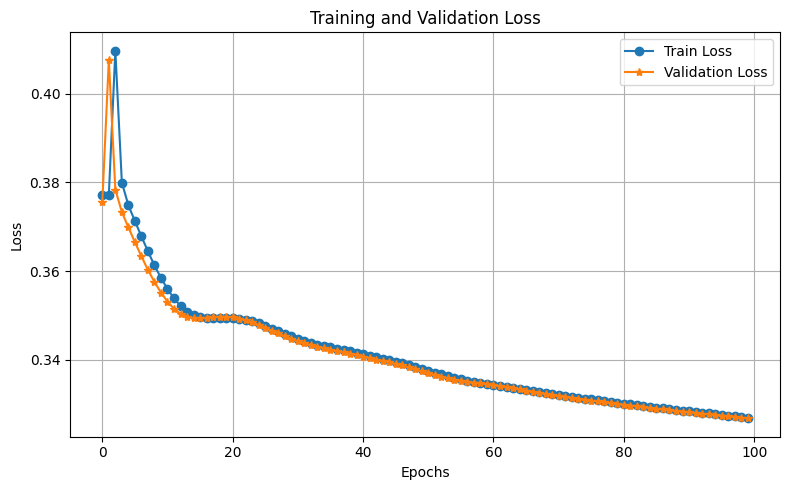

In [ ]:
# Plotting losses
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), final_train_loss, label="Train Loss", marker='o')
plt.plot(range(epochs), final_val_loss, label="Validation Loss", marker='*')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **2. Inference**

In this section, we will show how we can extract top N movies recommened for a specific user based on the trained GNN. Since we already have a test set of edges via `test_mask`, we will use this to demonstrate the inference.

Predict the ratings using the trained model and get rating for test set

In [ ]:
_, logits = evaluate_step(final_state, graph, labels=graph.edges, mask=test_mask)
predicted_ratings = np.array(logits[test_mask])
print(predicted_ratings)

[3.5917907 3.214677  4.488056  ... 3.9013715 4.2829247 4.0364037]


Next, let us extract the test set's user IDs and movie IDs from the edge_index.

In [ ]:
user_ids = data.edge_index[0][data.test_mask[:, 0]].numpy()
movie_ids = data.edge_index[1][data.test_mask[:, 0]].numpy()

Let us create a simple dataframe that contains the user IDs, and corresponding movie title and rating.

In [ ]:
# Map movie IDs to titles
movie_titles = [data.movie_id_to_title.get(movie_id) for movie_id in movie_ids]

predicted_ratings_df = pd.DataFrame({
    'user_id': user_ids,
    'movie_title': movie_titles,
    'predicted_rating': np.round(predicted_ratings, 3)
})

predicted_ratings_df.head()

,user_id,movie_title,predicted_rating
0,1,Sleeping Beauty (1959),3.592
1,3,"Godfather: Part II, The (1974)",3.215
2,12,Enemy (2013),4.488
3,14,P.S. I Love You (2007),3.497
4,32,Made (2001),3.465


Get the top N recommended movies for a user.

In [ ]:
user_id = 600 # user ID
assert user_id in set(user_ids), f"the user ID doesn't exist, please select from existing user IDs: {user_ids}"
N = 5

top_movies = predicted_ratings_df[predicted_ratings_df['user_id'] == user_id].sort_values(by='predicted_rating', ascending=False).head(N)
top_N = top_movies[['movie_title', 'predicted_rating']].values.tolist()

print(f'Top {len(top_N)} movies recommended for user ID {user_id} are:')

for number, (movie_title, rating) in enumerate(top_N):
    print(f'{number + 1}: {movie_title} with a predicted rating of {rating:.2f}')

Top 5 movies recommended for user ID 600 are:
1: House (1986) with a predicted rating of 4.66
2: Star Wars: Episode III - Revenge of the Sith (2005) with a predicted rating of 4.61
3: Rare Exports: A Christmas Tale (Rare Exports) (2010) with a predicted rating of 4.57
4: Black Panther (2017) with a predicted rating of 4.56
5: Romy and Michele's High School Reunion (1997) with a predicted rating of 4.30


Get the lowest N recommended movies for a user.

In [ ]:
# Get the bottom N lowest-rated movies for a user.

user_id = 600
assert user_id in set(user_ids), f"User ID doesn't exist, please select from existing user IDs: {user_ids}"
N = 2

bottom_movies = predicted_ratings_df[predicted_ratings_df['user_id'] == user_id].sort_values(by='predicted_rating', ascending=True).head(N)
bottom_N = bottom_movies[['movie_title', 'predicted_rating']].values.tolist()

print(f'Bottom {len(bottom_N)} lowest-rated movies recommended for user ID {user_id} are:')

for number, (movie_title, rating) in enumerate(bottom_N):
    print(f'{number + 1}: {movie_title} with a predicted rating of {rating:.2f}')


Bottom 2 lowest-rated movies recommended for user ID 600 are:
1: Barb Wire (1996) with a predicted rating of 3.83
2: Romy and Michele's High School Reunion (1997) with a predicted rating of 4.30


## Conclusion
**Summary:**

In this prac we introduced how we can use GNN models for recommender systems. For more understanding in this area, we recommend the following references.

**References:**
 - [CS224W: Machine Learning with Graphs](https://web.stanford.edu/class/cs224w/)
 - [Eugene Yan](https://eugeneyan.com/tag/recsys/) RecSys blog
 - [ACM RecSys YouTube](https://www.youtube.com/channel/UC2nEn-yNA1BtdDNWziphPGA)
 - [Recommendation Systems • Graph Neural Networks](https://aman.ai/recsys/gnn/)


For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2024).

# **Feedback**

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/WUpRupqfhFtbLXtN6",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />